In [1]:
import numpy as np
import copy

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
import dtnnlib as dtnn

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (9, 8)

In [2]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

## On 2D dataset

In [3]:
## Set 1
num_points = 50
X1 = np.linspace(-2.5, 1.5, num_points)
X2 = np.linspace(-2, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1.

In [4]:
# ## Set 2
# x1min, x1max, nx1 = -5, 6, 75
# x2min, x2max, nx2 = -3, 7, 75
# x1, x2 = np.linspace(x1min, x1max, nx1), np.linspace(x2min, x2max, nx2)
# X1, X2 = np.meshgrid(x1, x2)

# # Our function to fit is going to be a sum of two-dimensional Gaussians
# def gaussian(x1, x2, x10, x20, x1alpha, x2alpha, A):
#     return A * np.exp( -((x1-x10)/x1alpha)**2 -((x2-x20)/x2alpha)**2)

# # A list of the Gaussian parameters: x10, x20, x1alpha, x2alpha, A
# gprms = [(0, 2, 2.5, 5.4, 1.5),
#          (-1, 4, 6, 2.5, 1.8),
#          (-3, -0.5, 1, 2, 4),
#          (3, 0.5, 2, 1, 5)
#         ]

# Y = np.zeros(X1.shape)
# for p in gprms:
#     Y += gaussian(X1, X2, *p)

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  # This is added back by InteractiveShellApp.init_path()


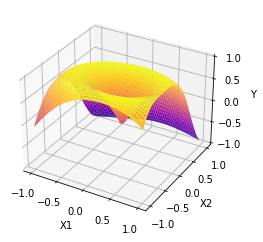

In [5]:
####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d')
# ax.scatter(X1, X2, Y)
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [6]:
xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))

### Developing shift based istereographic

In [7]:
class DistanceTransform_MinExp_epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, num_centers+1)*3/3))
        self.scaler = nn.Parameter(torch.log(torch.rand(1, num_centers+1)*2))

#         self.bias = nn.Parameter(torch.ones(1, num_centers+1)*0) if bias else None
        self.bias = nn.Parameter(torch.randn(1, num_centers+1)*0.1) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)

#         dists = torch.exp(-dists**2+self.scaler) ## the gaussian

#         dists = torch.exp(-(dists.abs())+self.scaler) ## works well with sqrt scaling or without
        dists = (1-dists)*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists


In [8]:
t = DistanceTransform_MinExp_epsilon(2, 5, epsilon=1.0)

In [9]:
t(torch.randn(7, 2)).shape

torch.Size([7, 6])

In [10]:
t(torch.randn(7, 2))

tensor([[-4.7741e-01, -4.7761e-01, -2.5385e+00, -9.2383e-02, -2.0214e+00,
         -4.2737e-01],
        [-2.2134e-01,  9.1786e-02, -5.7316e-01,  1.6302e-03, -1.8823e-01,
         -7.6940e-01],
        [-6.3663e-01, -1.9255e-01, -2.7948e+00, -7.7221e-02, -3.0924e-01,
         -9.1825e-01],
        [-8.5489e-01, -3.1629e-01, -3.7341e+00, -9.7166e-02, -1.2094e+00,
         -6.1175e-01],
        [-1.9251e-01, -7.1619e-02, -8.0086e-01, -3.2863e-02,  5.8504e-02,
         -1.0193e+00],
        [-9.6278e-01, -6.2458e-01, -4.8248e+00, -1.6103e-01, -1.9330e+00,
         -1.1534e+00],
        [-8.5416e-01, -3.4484e-01, -3.8398e+00, -1.0689e-01, -1.0926e+00,
         -7.4094e-01]], grad_fn=<MulBackward0>)

## Building 2D model

In [11]:
class LocalMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_MinExp_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)

#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = xo/xo.max(dim=1, keepdim=True)[0].detach()
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [12]:
model = LocalMLP(2, 10, 1).to(device)

In [13]:
model

LocalMLP(
  (layer0): DistanceTransform_MinExp_epsilon()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [14]:
yout = model.forward(xx)
xx.shape, yout.shape

(torch.Size([2500, 2]), torch.Size([2500, 1]))

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0031)
criterion = nn.MSELoss()

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


0 Error =  668.2180786132812
200 Error =  58.81923294067383
400 Error =  26.960630416870117
600 Error =  26.896324157714844
800 Error =  40.44118881225586
1000 Error =  183075.359375
1200 Error =  1463.3310546875
1400 Error =  1338.5394287109375
1600 Error =  141.22511291503906
1800 Error =  49.15888977050781
2000 Error =  35.753639221191406
2200 Error =  111.99365234375
2400 Error =  32.66006088256836
2600 Error =  25.779035568237305
2800 Error =  23.00777816772461
3000 Error =  56.75529861450195
3200 Error =  34.62108612060547
3400 Error =  26.326990127563477
3600 Error =  43.7056770324707
3800 Error =  21.161340713500977
4000 Error =  3363.921630859375
4200 Error =  3406.68310546875
4400 Error =  3750.001953125
4600 Error =  1994.3812255859375
4800 Error =  651.8685302734375


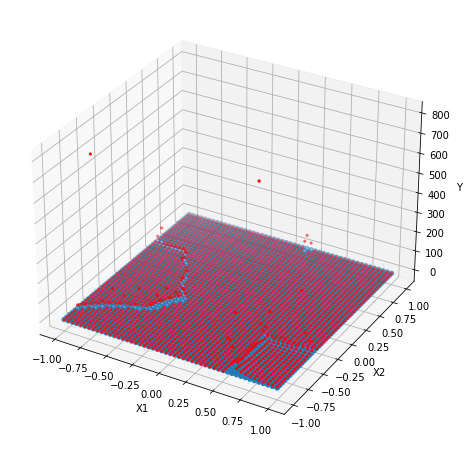

In [16]:
%matplotlib tk
fig = plt.figure(figsize=(9,8))
ax = fig.gca(projection='3d')

for epoch in range(5000):

    yout = model(xx)
    loss = criterion(yout, yy)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        print(epoch, 'Error = ', float(loss))
        ax.clear()
        
        ax.scatter(X1, X2, Y)
        ax.scatter(X1, X2, yout.data.reshape(Y.shape), color='r', marker='.')
        ax.set_xlabel('X1')
        ax.set_ylabel('X2')
        ax.set_zlabel('Y')
        
        fig.canvas.draw()
        plt.pause(0.01)

In [17]:
yout.shape, Y.shape

(torch.Size([2500, 1]), (50, 50))

/home/tsuman/Program_Files/Python/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  This is separate from the ipykernel package so we can avoid doing imports until


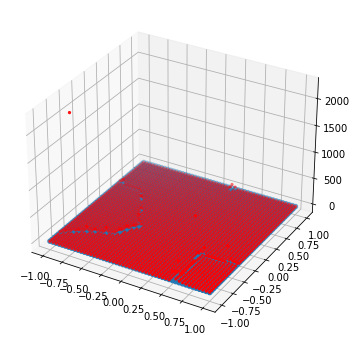

In [18]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.scatter(X1, X2, Y)
ax.scatter(X1, X2, yout.data.reshape(-1), color='r', marker='.')
plt.show()

## 1. Classification

In [19]:
def twospirals(n_points, noise=.5, angle=784):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * angle * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

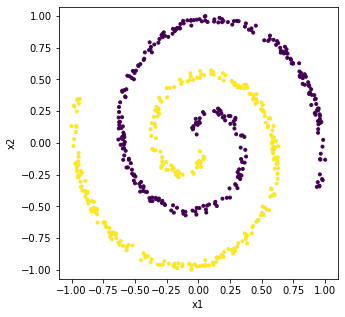

In [20]:
x, y = twospirals(300, angle=560)
x, y = x/x.max(axis=0, keepdims=True), y.reshape(-1)
xx, yy = torch.FloatTensor(x), torch.FloatTensor(y.reshape(-1,1))

x1 = xx[:,0]
x2 = xx[:,1]

%matplotlib inline
plt.figure(figsize=(5,5))
plt.scatter(x1, x2, c=y, marker='.')
# plt.savefig("./clf_toy_data.pdf")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

In [21]:
xx, yy = xx.to(device), yy.to(device)

In [22]:
H = 20
model = LocalMLP(2, H, 1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

Epoch: 99, Acc:0.78, Loss:0.5665262937545776
Epoch: 199, Acc:0.82, Loss:0.5339890718460083
Epoch: 299, Acc:0.88, Loss:0.5225026607513428
Epoch: 399, Acc:0.89, Loss:0.6854517459869385
Epoch: 499, Acc:0.91, Loss:0.8555535078048706
Epoch: 599, Acc:0.90, Loss:0.7124581933021545
Epoch: 699, Acc:0.90, Loss:0.5092052817344666
Epoch: 799, Acc:0.90, Loss:0.5045565962791443
Epoch: 899, Acc:0.89, Loss:0.5174712538719177
Epoch: 999, Acc:0.88, Loss:0.48761072754859924


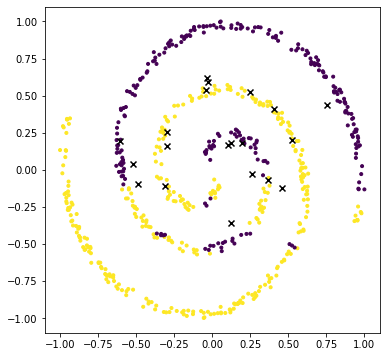

Epoch: 1099, Acc:0.88, Loss:0.4686022996902466
Epoch: 1199, Acc:0.89, Loss:0.4553803503513336
Epoch: 1299, Acc:0.91, Loss:0.4442974925041199
Epoch: 1399, Acc:0.92, Loss:0.4278675317764282
Epoch: 1499, Acc:0.93, Loss:0.4326578676700592
Epoch: 1599, Acc:0.95, Loss:0.3909895718097687
Epoch: 1699, Acc:0.96, Loss:0.3760543465614319
Epoch: 1799, Acc:0.98, Loss:0.35462650656700134
Epoch: 1899, Acc:0.97, Loss:0.34026020765304565
Epoch: 1999, Acc:0.97, Loss:0.32609570026397705


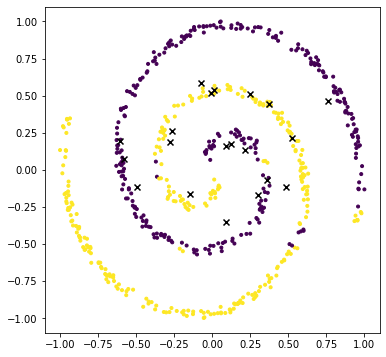

Epoch: 2099, Acc:0.96, Loss:0.3155718743801117
Epoch: 2199, Acc:0.97, Loss:0.3036636710166931
Epoch: 2299, Acc:0.97, Loss:0.2969244122505188
Epoch: 2399, Acc:0.98, Loss:0.2905268967151642
Epoch: 2499, Acc:0.98, Loss:0.2816840708255768
Epoch: 2599, Acc:0.98, Loss:0.2767147719860077
Epoch: 2699, Acc:0.98, Loss:0.26488715410232544
Epoch: 2799, Acc:0.98, Loss:0.25548413395881653
Epoch: 2899, Acc:0.98, Loss:0.2485518902540207
Epoch: 2999, Acc:0.98, Loss:0.2392420470714569


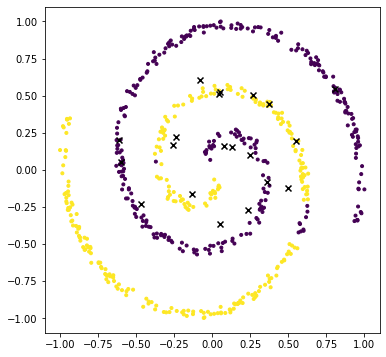

Epoch: 3099, Acc:0.98, Loss:0.23243026435375214
Epoch: 3199, Acc:0.97, Loss:0.23654192686080933
Epoch: 3299, Acc:0.98, Loss:0.22495025396347046
Epoch: 3399, Acc:0.98, Loss:0.22057901322841644
Epoch: 3499, Acc:0.99, Loss:0.215254545211792
Epoch: 3599, Acc:0.98, Loss:0.21295489370822906
Epoch: 3699, Acc:0.99, Loss:0.21472211182117462
Epoch: 3799, Acc:0.99, Loss:0.21289792656898499
Epoch: 3899, Acc:0.99, Loss:0.21348294615745544
Epoch: 3999, Acc:0.98, Loss:0.21226780116558075


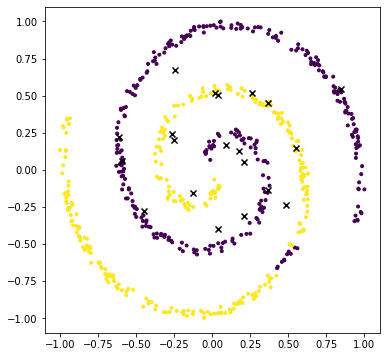

Epoch: 4099, Acc:0.99, Loss:0.20722900331020355
Epoch: 4199, Acc:0.99, Loss:0.20258063077926636
Epoch: 4299, Acc:0.99, Loss:0.19818076491355896
Epoch: 4399, Acc:0.99, Loss:0.19212137162685394
Epoch: 4499, Acc:0.99, Loss:0.18631163239479065
Epoch: 4599, Acc:0.99, Loss:0.1818968653678894
Epoch: 4699, Acc:0.99, Loss:0.17967024445533752
Epoch: 4799, Acc:0.99, Loss:0.17545080184936523
Epoch: 4899, Acc:0.99, Loss:0.17333956062793732
Epoch: 4999, Acc:0.99, Loss:0.17047366499900818


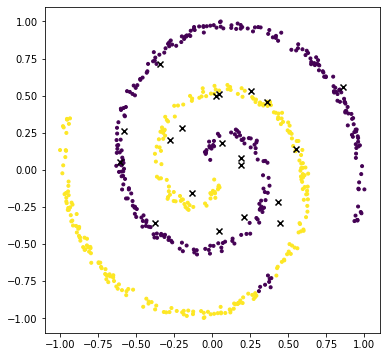

In [23]:
for epoch in range(5000):
    yout = torch.sigmoid(model(xx))
    loss = criterion(yout, yy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1)%100 == 0:
        accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()                
        print(f'Epoch: {epoch}, Acc:{float(accuracy):.2f}, Loss:{float(loss)}')

    if (epoch+1)%1000 == 0:
        ax = plt.figure(figsize=(6,6)).add_subplot()
        out = (yout.data.cpu().numpy()>0.5).astype(int)
        ax.scatter(x1, x2, c=out, marker= '.')
        ## plot centroids
        c = model.layer0.centers.data.cpu()
        ax.scatter(c[:,0], c[:,1], color='k', marker= 'x')
        plt.show()

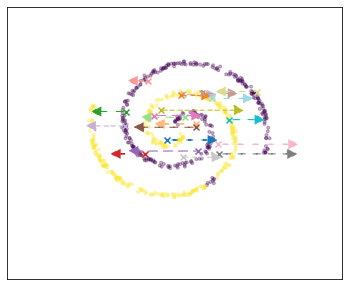

In [24]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t()*0.5 #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

## Softmax neuron

In [25]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_MinExp_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim+1, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach()
        
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

#### Random Init

In [26]:
H = 10
model = LocalMLP_epsilonsoftmax(2, H, 1, epsilon=1.0)
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_MinExp_epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [27]:
randidx = torch.randperm(len(xx))[:H]

In [28]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(0.6151266694068909, 0.6800000071525574)

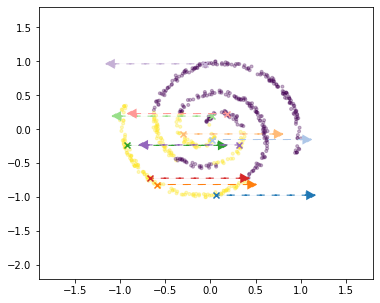

In [29]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [30]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

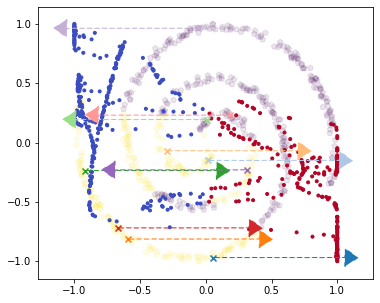

In [31]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

#### Visualize the confidence per neuron in a grid

In [32]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
#     xo = xo/xo.max(dim=1, keepdim=True)[0].detach()
    return xo

In [33]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

torch.Size([600, 11])
tensor([0.0804, 0.0827, 0.0417, 0.0644, 0.1164, 0.0773, 0.0446, 0.0859, 0.2713,
        0.0943, 0.0412]) 
  tensor([0.2631, 0.2443, 0.1589, 0.2129, 0.2176, 0.2103, 0.1727, 0.1916, 0.3072,
        0.2830, 0.0675])
tensor([1.9275e-26, 1.1800e-14, 1.9253e-18, 1.3039e-17, 5.6032e-10, 2.8068e-13,
        2.0026e-21, 1.2429e-10, 2.0188e-09, 1.6835e-34, 1.4637e-09]) 
  tensor([1.0000, 1.0000, 0.9855, 1.0000, 0.8582, 0.9953, 0.8827, 0.7990, 0.9134,
        1.0000, 0.2812])


In [34]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [35]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

torch.Size([1000, 1000, 11])

(1000, 1000)


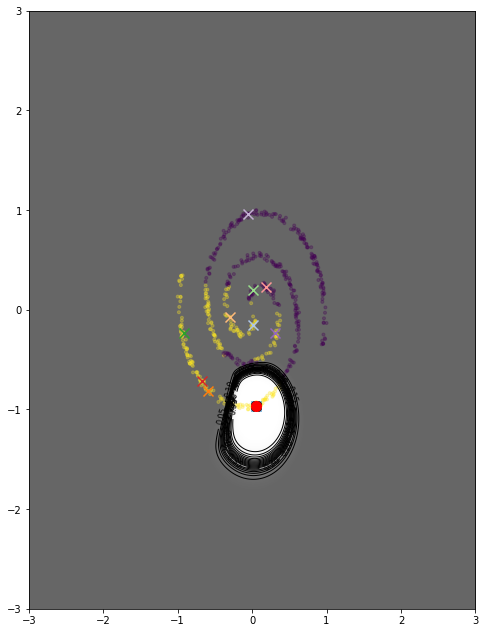

(1000, 1000)


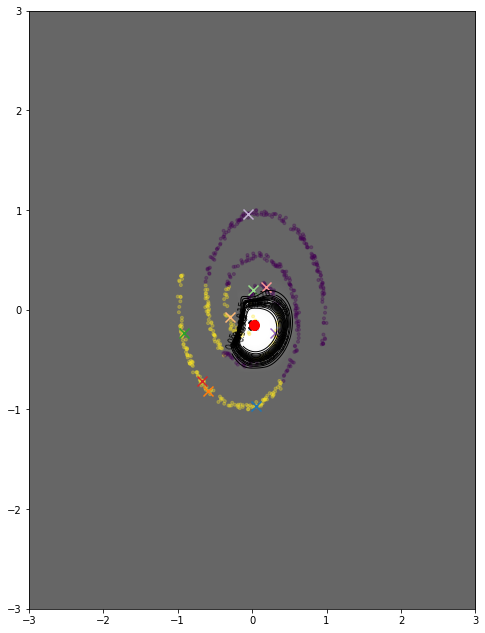

(1000, 1000)


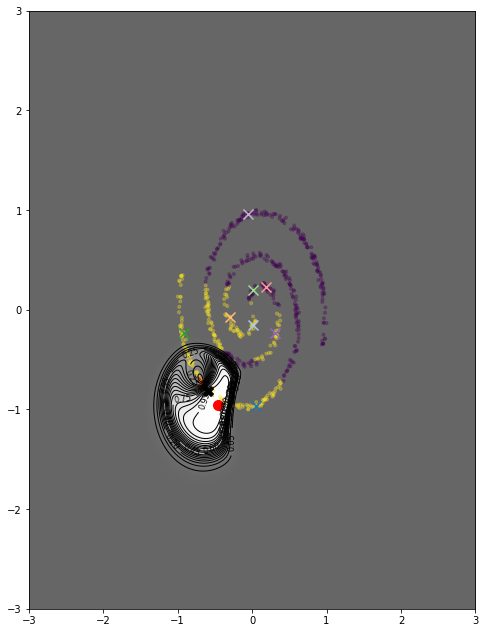

(1000, 1000)


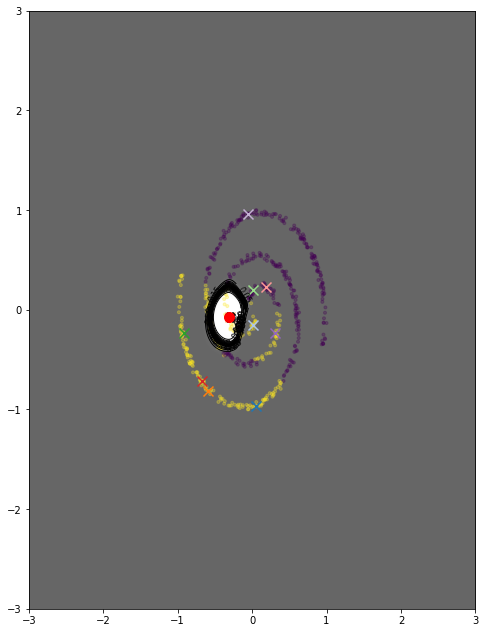

(1000, 1000)


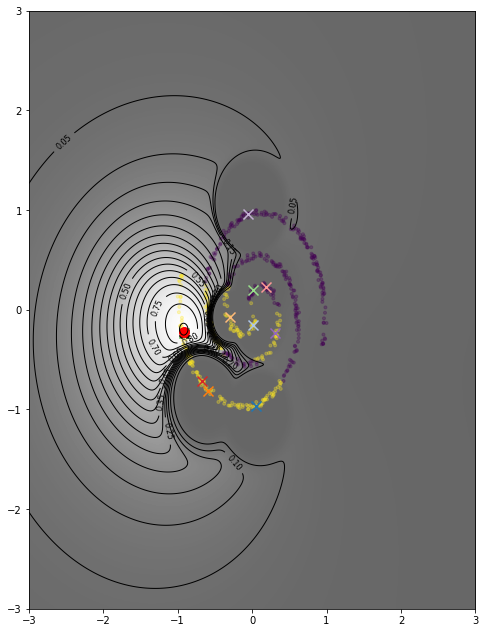

(1000, 1000)


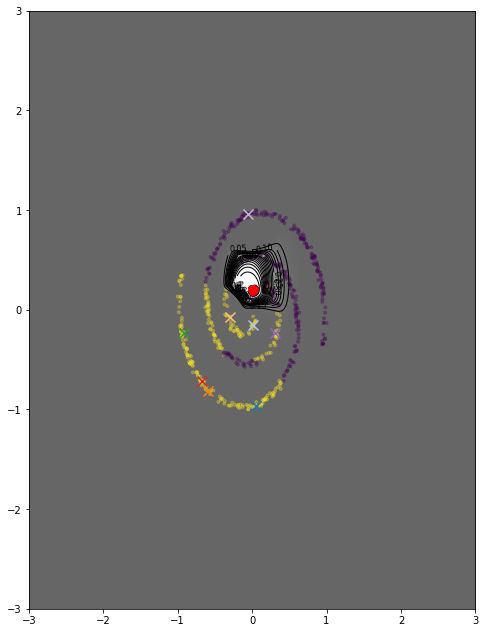

(1000, 1000)


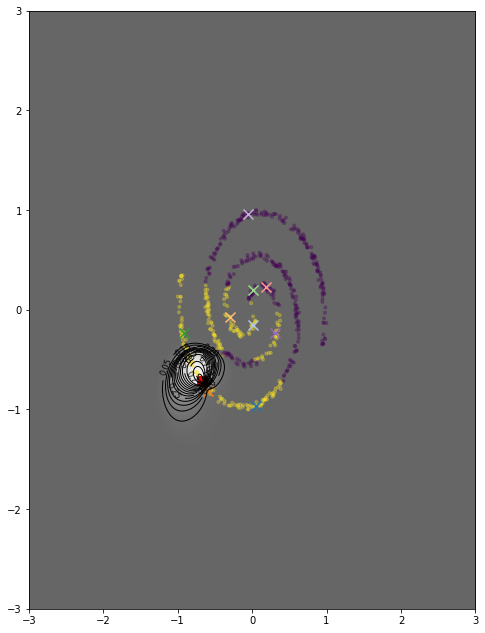

(1000, 1000)


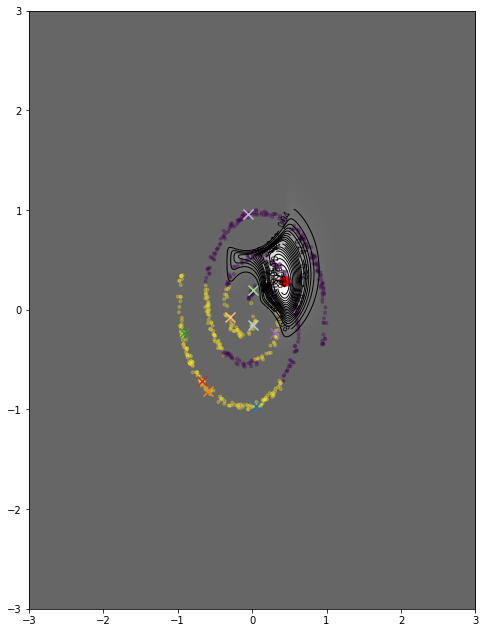

(1000, 1000)


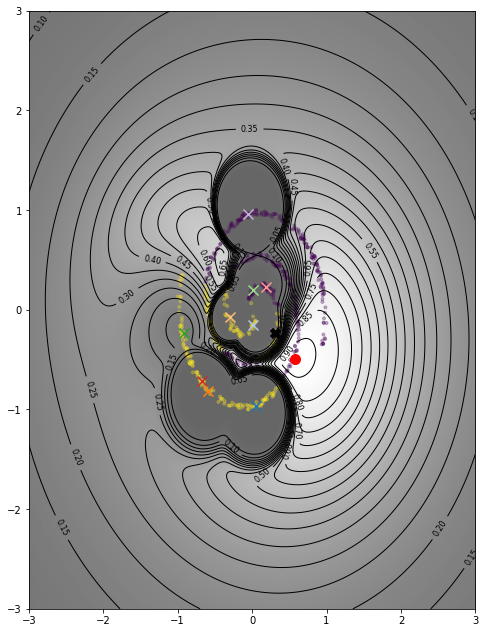

(1000, 1000)


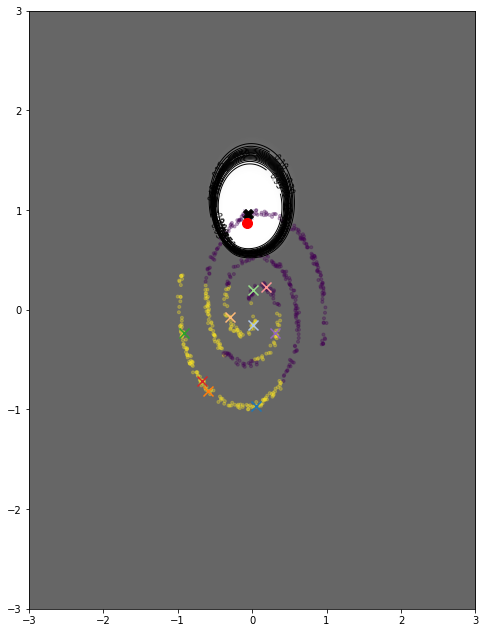

(1000, 1000)


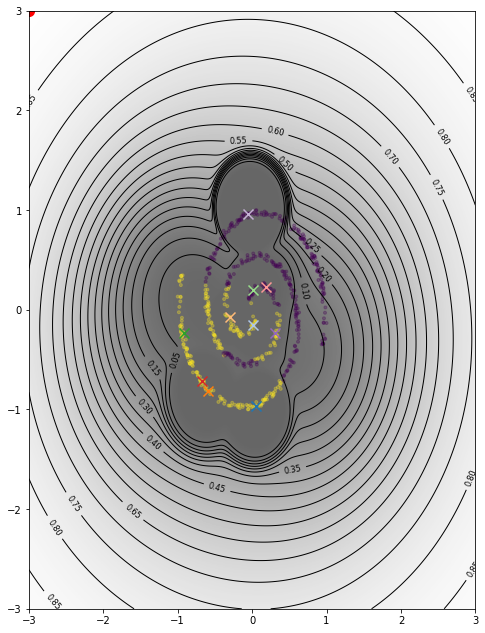

In [36]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,11)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [37]:
model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_MinExp_epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [38]:
"""
- softmax based distance-epsilon-exp:
    -> creates maxima != center if d-d_min & /std is used 
    -> minima == center if d is not normalized but d-d_min 
    -> minima != center if d is normalized but d_min not subtracted (lies inside highest actf contour)
    
- softmax based distance-epsilon: (without exp)
    - d-d_min/std -> center lies inside contour of highest actv (collapsed contourlines) -> similar to ^^
    - d/std -> center != minima
    - d-d_min -> center == minima ^^



=====> using scaling of distances individually causes center != maxima for softmax dt
"""

'\n- softmax based distance-epsilon-exp:\n    -> creates maxima != center if d-d_min & /std is used \n    -> minima == center if d is not normalized but d-d_min \n    -> minima != center if d is normalized but d_min not subtracted (lies inside highest actf contour)\n    \n- softmax based distance-epsilon: (without exp)\n    - d-d_min/std -> center lies inside contour of highest actv (collapsed contourlines) -> similar to ^^\n    - d/std -> center != minima\n    - d-d_min -> center == minima ^^\n\n\n\n=====> using scaling of distances individually causes center != maxima for softmax dt\n'

In [39]:
# asdasdasd

In [40]:
# LocalMLP_epsilonsoftmax(   ===> This produces the best looking decision boundary
#   (layer0): DistanceTransform_MinExp_epsilon()
#   (scale_shift): ScaleShift()
#   (softmax): Softmax(dim=-1)
#   (activ): OneActiv()
#   (layer1): Linear(in_features=11, out_features=1, bias=True)
# )

## Confidence without softmax

In [41]:
H = 10
model = LocalMLP(2, H, 1, epsilon=1.0)
model

LocalMLP(
  (layer0): DistanceTransform_MinExp_epsilon()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [42]:
randidx = torch.randperm(len(xx))[:H]

In [43]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

(11.440271377563477, 0.6583333611488342)

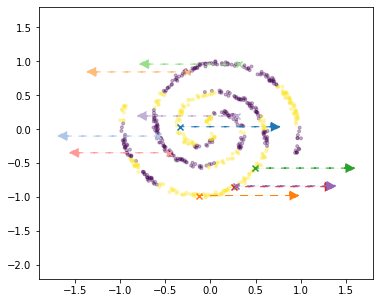

In [44]:
yout = torch.sigmoid(model(xx))
ax = plt.figure(figsize=(6,5)).add_subplot()
out = (yout.data.cpu().numpy()>0.5).astype(int)
ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)
## plot centroids
c = model.layer0.centers.data.cpu()
# ax.scatter(c[:,0], c[:,1], color='g', marker= 'x')
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
# print(d.shape)

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.05, head_length=0.1, fc='k', ec='k')
#     ax.arrow(c[i,0], c[i,1], d[i,0], d[i,1], head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')
    
# plt.tick_params(left = False, right = False , labelleft = False ,
#                 labelbottom = False, bottom = False)
plt.xlim(-1.9, 1.8)
plt.ylim(-2.2, 1.8)

# plt.savefig("./outputs/", bbox_inches='tight')
plt.show()

In [45]:
yout.shape, out.shape

(torch.Size([600, 1]), (600, 1))

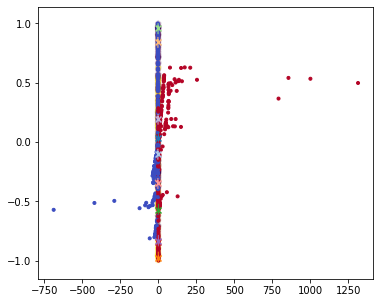

In [46]:
# yout = torch.sigmoid(model(xx))
yout = model(xx)
ax = plt.figure(figsize=(6,5)).add_subplot()
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

ax.scatter(x1, x2, c=out, marker= 'p', alpha=0.1)

# ax.scatter(yout[:,0].data.numpy(), [0]*len(yout), c=out, marker= '.', alpha=0.3)
ax.scatter(yout[:,0].data.numpy(), x2, c=out, marker= '.', alpha=1.0, cmap="coolwarm")
## plot centroids
c = model.layer0.centers.data.cpu()
d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()

for i in range(c.shape[0]):
    color = matplotlib.cm.tab20(i%20)
    ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
    ax.scatter(c[i,0], c[i,1], color=color, marker= 'x')

# plt.xlim(-1.9, 1.8)
# plt.ylim(-2.2, 1.8)
plt.show()

#### Visualize the confidence per neuron in a grid

In [47]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    return xo

In [48]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

torch.Size([600, 11])
tensor([-1.1473, -2.0887, -1.2531, -2.0234, -2.3166, -0.6305, -1.5225, -0.1180,
        -1.8889, -1.1317, -2.1076], grad_fn=<MeanBackward1>) 
  tensor([1.1248, 2.1428, 0.8605, 1.3059, 1.3854, 0.4502, 0.8671, 0.0183, 1.2291,
        0.8562, 0.7707], grad_fn=<StdBackward1>)
tensor([-4.1858, -7.2840, -2.7911, -4.5148, -4.7661, -1.2877, -2.7434, -0.1612,
        -3.5812, -2.7796, -4.0411], grad_fn=<MinBackward0>) 
  tensor([ 1.1895,  1.7180,  0.6261,  0.9859,  1.6057,  0.4633,  0.6754, -0.0854,
         1.2561,  1.1782, -0.9418], grad_fn=<MaxBackward0>)


In [49]:
xo

tensor([[-1.7523, -3.5360, -1.1734,  ..., -0.9566, -0.8315, -3.1030],
        [ 0.2099,  0.9657, -0.5772,  ..., -1.3686, -1.5543, -1.8392],
        [-3.9192, -6.9691, -2.7713,  ..., -3.5269, -1.4660, -3.0218],
        ...,
        [-0.6730, -2.2980, -1.5313,  ..., -2.1953, -1.0861, -3.8532],
        [-3.0518, -5.8521, -2.3158,  ..., -2.6699, -0.5129, -3.5564],
        [-0.9706, -1.1413,  0.5795,  ...,  0.3111, -1.5906, -1.0640]],
       grad_fn=<AddBackward0>)

In [50]:
num_points = 1000
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [51]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

torch.Size([1000, 1000, 11])

(1000, 1000)


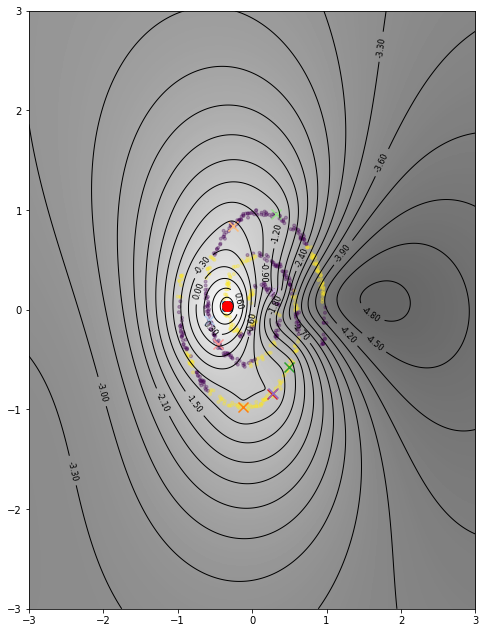

(1000, 1000)


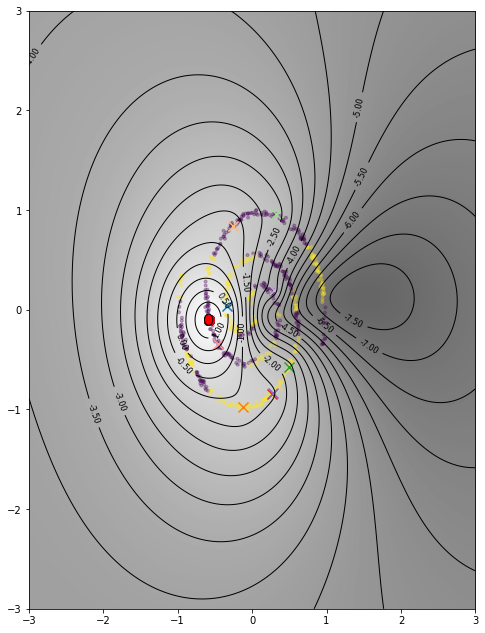

(1000, 1000)


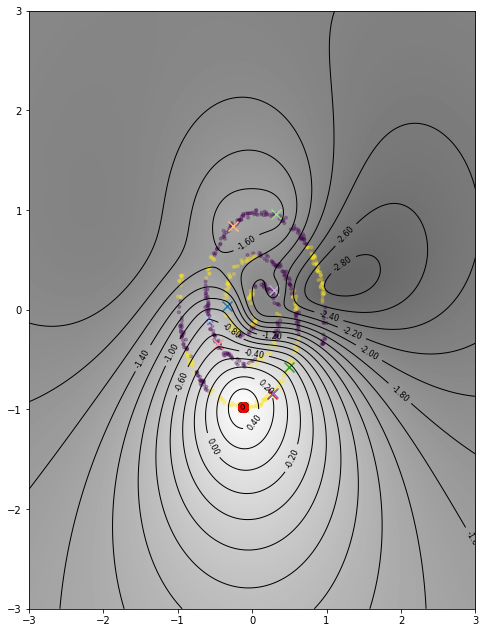

(1000, 1000)


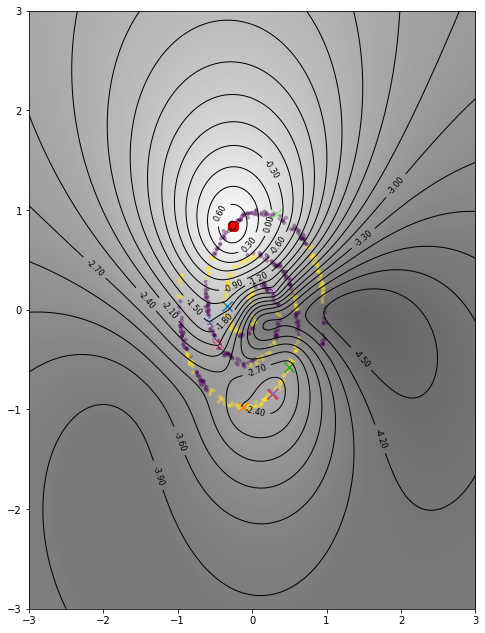

(1000, 1000)


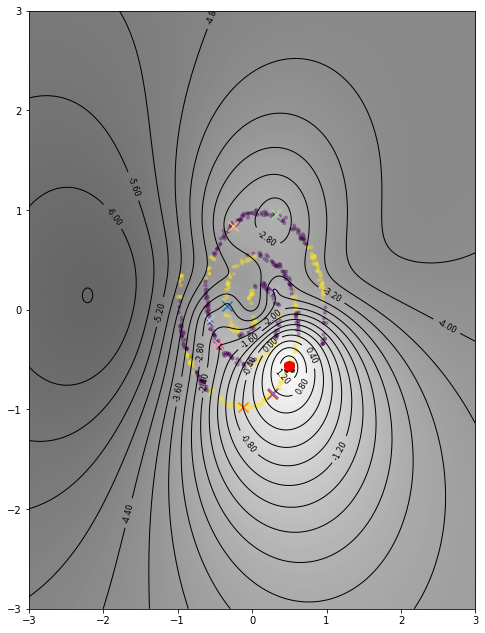

(1000, 1000)


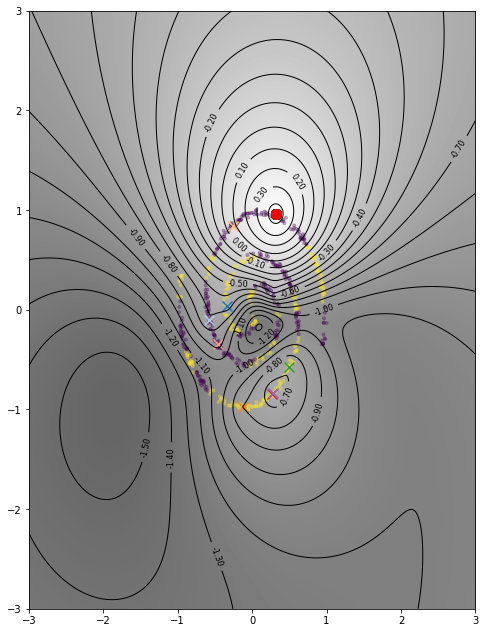

(1000, 1000)


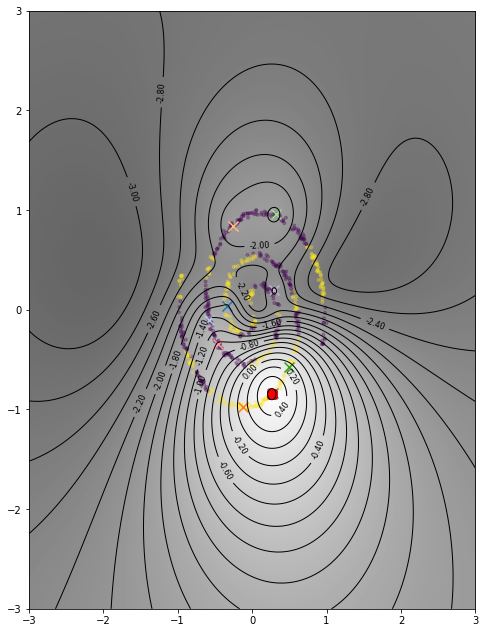

(1000, 1000)


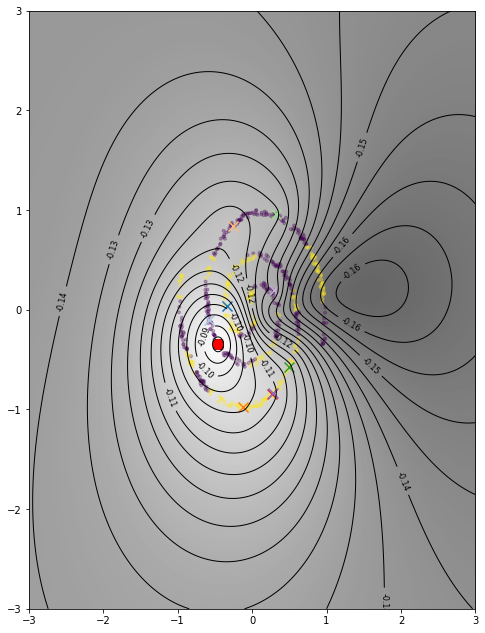

(1000, 1000)


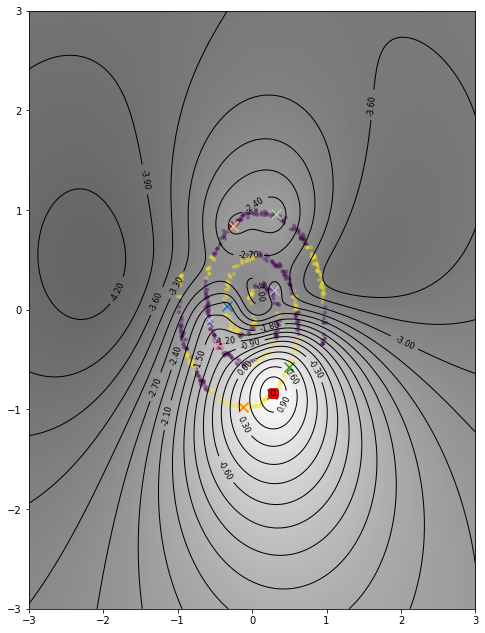

(1000, 1000)


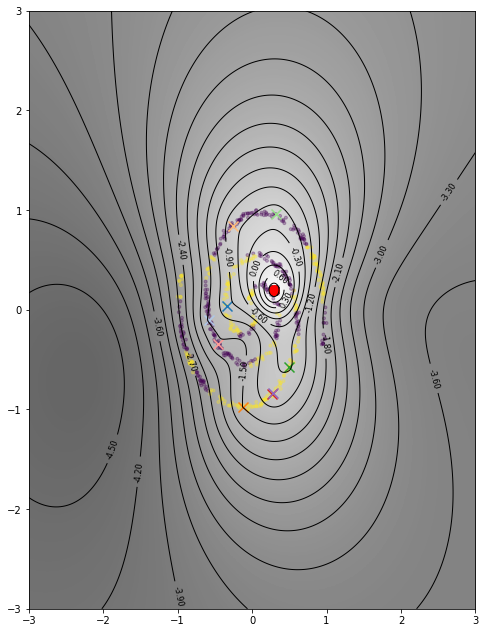

(1000, 1000)


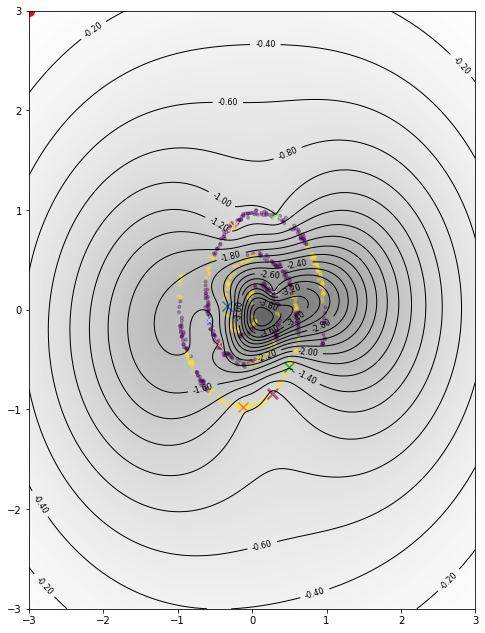

In [52]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,11)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [53]:
model

LocalMLP(
  (layer0): DistanceTransform_MinExp_epsilon()
  (activ): OneActiv()
  (layer1): Linear(in_features=11, out_features=1, bias=True)
)

In [54]:
"""
DT_min_exp_epsilon:
- with d-d_min -> the center!=maxima? (or multiple maximas) but lies in maximum contour which is bounded (not that bad)
- with d/std -> the center == maxima ; but the epsilon neuron fires disproportionly (not perfect enclosing centers)
- with both d-d_min / std -> multiple maximas with minima inside the contour of highest activation.

DT_min_epsilon
- with d-d_min / std -> similar to  ^^
- with d-d_min -> ^^
- with d/std -> ^^

::: The distance must only be scaled by monotonic function to keep center at minima
"""

'\nDT_min_exp_epsilon:\n- with d-d_min -> the center!=maxima? (or multiple maximas) but lies in maximum contour which is bounded (not that bad)\n- with d/std -> the center == maxima ; but the epsilon neuron fires disproportionly (not perfect enclosing centers)\n- with both d-d_min / std -> multiple maximas with minima inside the contour of highest activation.\n\nDT_min_epsilon\n- with d-d_min / std -> similar to  ^^\n- with d-d_min -> ^^\n- with d/std -> ^^\n\n::: The distance must only be scaled by monotonic function to keep center at minima\n'

In [55]:
asasasa

NameError: name 'asasasa' is not defined

## Scaling distances with KNN-scaling

In [ ]:
def get_sigma(dists, k=50, epoch=700, lr=0.03):
    ratio = k/dists.shape[1]
    dists = torch.topk(dists.data, k=k,dim=1)[0]
    sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*ratio)
    optim = torch.optim.Adam([sigma], lr=lr)
    target = torch.log2(torch.ones_like(sigma)*k).to(dists.device)
#     print(sigma, target)
    for i in range(epoch):
#         print(i)
        _delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
#         print(sigma.data, delta.data)
        delta = _delta-target

        optim.zero_grad()
        error = (delta**2).sum()
        error.backward()
        optim.step()
#     print(sigma, delta)
    del optim, target, dists
    return sigma.data

In [ ]:
class DistanceTransform_MinExpKNN_epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.log(torch.ones(1, num_centers+1)*3/3))
        self.bias = nn.Parameter(torch.ones(1, num_centers+1)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)

        sigma = get_sigma(dists, k=len(self.centers)-1, epoch=1000)
        dists = dists/(sigma+1e-9)

#         dists = torch.exp(-dists**2+self.scaler) ## the gaussian

#         dists = torch.exp(-(dists.abs())+self.scaler) ## works well with sqrt scaling or without
        dists = (1-dists)*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists


In [ ]:
t = DistanceTransform_MinExpKNN_epsilon(2, 5, epsilon=1.0)

In [ ]:
t(torch.randn(7, 2)).shape

In [ ]:
t(torch.randn(7, 2))

## With and Without softmax

In [ ]:
class LocalMLP(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_MinExpKNN_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)

#         self.activ = dtnn.OneActiv(self.hidden_dim, mode='exp_1.6')
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [ ]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_MinExpKNN_epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        self.scale_shift = dtnn.ScaleShift(self.hidden_dim+1, scaler_init=10, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
        self.activ = dtnn.OneActiv(self.hidden_dim+1, mode='relu')
        self.layer1 = nn.Linear(self.hidden_dim+1, self.output_dim)
        
    def forward(self, x):
        xo = self.layer0(x)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [ ]:
H = 10
# model = LocalMLP(2, H, 1, epsilon=1.0)
model = LocalMLP_epsilonsoftmax(2, H, 1, epsilon=1.0)
model

In [ ]:
randidx = torch.randperm(len(xx))[:H]

In [ ]:
model.layer0.centers.data = xx[randidx] 

## Mapping like MLP
out = (yy[randidx].t()*2-1)*1.0
out = torch.cat([out, torch.ones(1, 1)*0.], dim=1)
model.layer1.weight.data = out
# print(model.layer1.weight.data.shape, yy[randidx].t().shape)

## Residual like difference
# sign = yy[randidx].t()*2-1
# xval = xx[randidx, 0]
# diff = sign-xval
# model.layer1.weight.data = diff


model.layer1.bias.data *= 0.
yout = torch.sigmoid(model(xx))
loss = criterion(yout, yy)
accuracy = ((yout>0.5).type(torch.float32) == yy).type(torch.float).mean()
loss.item(), accuracy.item()

In [ ]:
yout = model(xx)
# out = (yout.data.cpu().numpy()>0.5).astype(int)
out = (yout.data.cpu().numpy()>0.0).astype(int)

#### Visualize the confidence per neuron in a grid

In [ ]:
# def forward_intermediate(self, x):
#     xo = self.layer0(x)
#     return xo

In [ ]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    return xo

In [ ]:
xo = forward_intermediate(model, xx)

print(xo.shape)
print(xo.mean(dim=0), "\n ", xo.std(dim=0))
print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

In [ ]:
xo

In [ ]:
num_points = 300
X1 = np.linspace(-1.5, 1.5, num_points)*2
X2 = np.linspace(-1.5, 1.5, num_points)*2
X1, X2 = np.meshgrid(X1, X2)

XX = torch.Tensor(np.c_[X1.reshape(-1), X2.reshape(-1)]).to(device)

In [ ]:
YY = forward_intermediate(model, XX)
YY = YY.reshape(num_points, num_points, H+1)
YY.shape

In [ ]:
for idx in range(xo.shape[1]):
    conf = YY[:,:,idx]
    conf = conf.data.cpu().numpy().reshape(X1.shape)
    print(conf.shape)
    
    ax = plt.figure(figsize=(8,11)).add_subplot()

    ax.scatter(x1, x2, c=out, marker= '.', alpha=0.3)

    ## plot centroids
    c = model.layer0.centers.data.cpu()
#     d = model.layer1.weight.data.cpu().t() #+ net.net[-1].bias.data.cpu()
    for i in range(c.shape[0]):
        color = matplotlib.cm.tab20(i%20)
#         ax.arrow(c[i,0], c[i,1], d[i,0], 0, head_width=0.15, head_length=0.1, fc=color, ec=color, linestyle=(0, (5, 10)))
        ax.scatter(c[i,0], c[i,1], color=color, marker= 'x', s=100)
    
    try:
        ax.scatter(c[idx,0], c[idx,1], color="k", marker= 'X', s=100)
    except:
        pass
    
#     maxpt = np.unravel_index(conf.argmax(), conf.shape)
    maxpt = XX[conf.argmax()]
    ax.scatter(maxpt[0], maxpt[1], color="r", marker= 'o', s=100)
#     print(maxpt)
    
    plt.imshow(conf, interpolation='nearest',
           extent=(X1.min(), X1.max(), X2.min(), X2.max()),
           alpha=0.6, cmap='gray',
           aspect='auto', origin='lower')
    
    LVLs = 20
#     ax.contourf(X1, X2, conf, levels=LVLs)
    cs = ax.contour(X1, X2, conf, levels=LVLs, linestyles="None", colors="k", linewidths=1)
    ax.clabel(cs, cs.levels, inline=True, fontsize=8, fmt="%1.2f")
    
    # plt.xlim(-1.9, 1.8)
    # plt.ylim(-2.2, 1.8)
    plt.show()
#     break

In [ ]:
"""
W/O softmax
    The output is similar to ^^ scaling by standard deviation (highest contour at minimal distance) 
            & well scaling of epsilon contour

W softmax
    - d-d_min/std -> center != maxima
    - d/std -> center == minima
    - d-d_min -> center != maxima (looks like equal for (1-dist) simple;)
"""

In [ ]:
"""
For toy:
Add seperate epsilon per neuron, bias and scale; make confidence and prediction as desired

For highDim:
Make the net train in high dim with center at maxima and good epsilon confidence
"""